## Configurações iniciais

### Importação das bibliotecas utilizadas

In [97]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import pandas as pd
from PIL import Image
from sklearn.metrics import precision_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

### Configurações gerais

In [98]:
data_path = '/kaggle/input/sports-classification'
working_path = '/kaggle/working'
historic_path = '/kaggle/input/historico/Histrico dos modelos.xlsx'
batch_size = 50
dtype = torch.float16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Funções

### Funções para salvar e carregar modelos

In [99]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def invert_dict(d):
    inverted_dict = {}
    for key, value in d.items():
        if value not in inverted_dict:
            inverted_dict[value] = [key]
        else:
            inverted_dict[value].append(key)
    inverted_dict = dict(sorted(inverted_dict.items()))
    return inverted_dict

### Função de treino

In [100]:
def evaluate_model(model, loader, loss, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            l = loss(y_hat.float(), y)
            total_loss += l.item() * X.size(0)
            predicted_labels = torch.argmax(y_hat, dim=1)
            correct_predictions += (predicted_labels == y).sum().item()
            total_samples += y.size(0)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted_labels.cpu().numpy())

    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return average_loss, accuracy, precision, f1

In [101]:
def fit(epochs, model, train_loader, test_loader, optimizer, loss, scheduler, device):
    train_loss_values = []
    train_acc_values = []
    train_precision_values = []
    train_f1_values = []
    test_loss_values = []
    test_acc_values = []
    test_precision_values = []
    test_f1_values = []
    learning_rates = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0
        all_labels = []
        all_preds = []

        for X, y in tqdm(train_loader, desc=f'Época {epoch + 1}/{epochs}'):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat.float(), y)
            l.backward()
            optimizer.step()
            epoch_loss += l.item() * X.size(0)
            predicted_labels = torch.argmax(y_hat, dim=1)
            correct_predictions += (predicted_labels == y).sum().item()
            total_samples += X.size(0)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted_labels.cpu().numpy())

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        learning_rates.append(current_lr)

        epoch_loss /= total_samples
        epoch_acc = correct_predictions / total_samples
        epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        train_loss_values.append(epoch_loss)
        train_acc_values.append(epoch_acc)
        train_precision_values.append(epoch_precision)
        train_f1_values.append(epoch_f1)

        test_metrics = evaluate_model(model, test_loader, loss, device)
        test_loss_values.append(test_metrics[0])
        test_acc_values.append(test_metrics[1])
        test_precision_values.append(test_metrics[2])
        test_f1_values.append(test_metrics[3])

        print(f'\tTreino - Perda: {epoch_loss:6.4f}, Acurácia: {epoch_acc * 100:6.2f}%, Precisão: {epoch_precision * 100:6.2f}%, F1: {epoch_f1 * 100:6.2f}%')
        print(f'\tTeste  - Perda: {test_metrics[0]:6.4f}, Acurácia: {test_metrics[1] * 100:6.2f}%, Precisão: {test_metrics[2] * 100:6.2f}%, F1: {test_metrics[3] * 100:6.2f}%')
        print(f'\tTaxa de aprendizado: {current_lr:.6f}')

    return model, {
        'train_loss': train_loss_values,
        'train_accuracy': train_acc_values,
        'train_precision': train_precision_values,
        'train_f1': train_f1_values,
        'test_loss': test_loss_values,
        'test_accuracy': test_acc_values,
        'test_precision': test_precision_values,
        'test_f1': test_f1_values,
        'learning_rates': learning_rates
    }

### Função para organizar os dados numa tabela

In [102]:
def organize_data(data):
    epochs = len(data['train_loss'])
    df = pd.DataFrame({
        'Época': [i for i in range(1, epochs + 1)],
        'Perda no treino': data['train_loss'],
        'Acurácia no treino': data['train_accuracy'],
        'Precisão no treino': data['train_precision'],
        'F1 no treino': data['train_f1'],
        'Perda no teste': data['test_loss'],
        'Acurácia no teste': data['test_accuracy'],
        'Precisão no teste': data['test_precision'],
        'F1 no teste': data['test_f1'],
        'Taxa de aprendizado': data['learning_rates'],
    })
    df = df.set_index('Época')
    return df

def reorganize_data(df):
    df = df.map(lambda x: float(x.strip('%')) / 100 if isinstance(x, str) and '%' in x else x)
    return df

def format_dataframe(data, decimal=2):
    df = data if isinstance(data, pd.DataFrame) else organize_data(data)

    format_decimal = lambda x: f'{round(x, decimal):.{decimal}f}'.replace('.', ',')
    format_percentage = lambda x: f'{round(x * 100, decimal):.{decimal}f}%'

    df['Perda no treino'] = df['Perda no treino'].apply(format_decimal)
    df['Acurácia no treino'] = df['Acurácia no treino'].apply(format_percentage)
    df['Precisão no treino'] = df['Precisão no treino'].apply(format_percentage)
    df['F1 no treino'] = df['F1 no treino'].apply(format_percentage)
    df['Perda no teste'] = df['Perda no teste'].apply(format_decimal)
    df['Acurácia no teste'] = df['Acurácia no teste'].apply(format_percentage)
    df['Precisão no teste'] = df['Precisão no teste'].apply(format_percentage)
    df['F1 no teste'] = df['F1 no teste'].apply(format_percentage)
    df['Taxa de aprendizado'] = df['Taxa de aprendizado'].apply(lambda x: f'{x:.6f}'.replace('.', ','))

    return df

### Função para fazer um gráfico dos resultados

In [103]:
def plot_metrics(data):
    df = data if isinstance(data, pd.DataFrame) else organize_data(data)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharex=True)

    metrics = [
        'Perda no treino', 'Perda no teste', 'Acurácia no treino', 'Acurácia no teste',
        'Precisão no treino', 'Precisão no teste', 'F1 no treino', 'F1 no teste',
    ]
    titles = ['Perda', 'Acurácia', 'Precisão', 'F1']

    for i, ax in enumerate(axes.flat):
        train_metric = metrics[i * 2]
        test_metric = metrics[i * 2 + 1]
        title = titles[i]

        ax.plot(df.index, df[train_metric], label=f'{train_metric}', color='blue')
        ax.plot(df.index, df[test_metric], label=f'{test_metric}', color='red')
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(f'{title} em relação às Épocas', fontsize=14)
        if 'Acurácia' in title or 'Precisão' in title or 'F1' in title:
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))
        ax.legend(fontsize=10)
        ax.grid()

    plt.tight_layout()
    plt.show()

### Funções de validação

In [104]:
def validate_accuracy(model, valid_loader, device):
    model.eval()
    num_classes = len(valid_loader.dataset.dataset.classes)
    class_correct = {i: 0 for i in range(num_classes)}
    class_total = {i: 0 for i in range(num_classes)}

    with torch.no_grad():
        for X, y in valid_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            predicted_labels = torch.argmax(y_hat, dim=1)
            correct = (predicted_labels == y).squeeze()

            for i in range(len(y)):
                label = y[i]
                class_correct[label.item()] += correct[i].item()
                class_total[label.item()] += 1

    class_accuracy = {i: class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)}
    overall_accuracy = sum(class_correct.values()) / sum(class_total.values()) if sum(class_total.values()) > 0 else 0

    return overall_accuracy, class_accuracy

In [105]:
def show_predictions(model, valid_loader, classes, device, title='Predições', batchs=1, nrow=10, padding=100, pad_value=100):
    model.eval()

    for b, (images, labels) in enumerate(valid_loader):
        if b == batchs:
            break

        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

        images = images.to(torch.float32)
        image_grid = make_grid(images.cpu(), nrow=nrow, padding=padding, pad_value=pad_value)
        image_grid = image_grid.permute(1, 2, 0)

        plt.figure(figsize=(15, 15))
        plt.imshow(image_grid)
        plt.title(title)
        plt.axis('off')

        for i in range(images.size(0)):
            true_label = classes[labels[i].item()][:12].capitalize()
            predicted_label = classes[predicted[i].item()][:12].capitalize()
            row = i // nrow
            col = i % nrow
            x = col * (images.size(3) + padding) + padding
            y = row * (images.size(2) + padding) + padding * 0.8
            color = 'green' if true_label == predicted_label else 'red'
            plt.text(x, y, f'True: {true_label}\nPred: {predicted_label}', color=color, fontsize=6)
        plt.show()

### Funções de predição

In [106]:
def predict_image(model, image_path, classes, dtype=torch.float32, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], device='cpu'):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(dtype=dtype),
        transforms.Normalize(mean=mean, std=std),
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    prediction = classes[predicted.item()]

    original_image = transforms.ToTensor()(image).permute(1, 2, 0)
    transformed_image = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
    transformed_image = transformed_image * std + mean
    transformed_image = transformed_image.clip(0, 1)

    plt.figure(figsize=(7, 7))
    plt.imshow(transformed_image)
    plt.axis('off')
    plt.title(f'Predição: {prediction.capitalize()}')
    plt.show()

## Dataset

### Preparação do dataset

In [107]:
test_fraction = 1
train_fraction = 1
valid_fraction = 1
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=dtype),
    transforms.Normalize(mean=mean, std=std),
])
train_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.3),
#     transforms.RandomVerticalFlip(p=0.05),
#     transforms.RandomAffine(degrees=20, translate=(0.05, 0.05), scale=(0.8, 1.2)),
#     transforms.RandomRotation(degrees=(0, 20)),
#     transforms.RandomResizedCrop(size=224, scale=(0.85, 1.15)),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
#     transforms.RandomPerspective(distortion_scale=0.05, p=0.2),
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 7)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.RandomErasing(p=0.2, scale=(0.05, 0.2), ratio=(0.3, 3.3)),
    transforms.ConvertImageDtype(dtype=dtype),
    transforms.Normalize(mean=mean, std=std),
])
valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomRotation(degrees=(20, 50)),
#     transforms.ColorJitter(brightness=0.3, contrast=0.1, saturation=0.4, hue=0.05),
#     transforms.RandomHorizontalFlip(p=0.4),
#     transforms.RandomVerticalFlip(p=0.1),
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 5)),
    transforms.ToTensor(),
#     transforms.RandomErasing(p=0.3, scale=(0.05, 0.40), ratio=(0.3, 3.3)),
    transforms.ConvertImageDtype(dtype=dtype),
    transforms.Normalize(mean=mean, std=std),
])

test_dataset = ImageFolder(
    root=f'{data_path}/test',
    transform=test_transforms,
)
train_dataset = ImageFolder(
    root=f'{data_path}/train',
    transform=train_transforms,
)
valid_dataset = ImageFolder(
    root=f'{data_path}/valid',
    transform=valid_transforms,
)

test_size = int(test_fraction * len(test_dataset))
train_size = int(train_fraction * len(train_dataset))
valid_size = int(valid_fraction * len(valid_dataset))

test_dataset = Subset(test_dataset, range(test_size))
train_dataset, _ = random_split(
    train_dataset,
    [train_size, len(train_dataset) - train_size],
)
valid_dataset = Subset(valid_dataset, range(valid_size))

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print(f'Tamanho de teste: {len(test_dataset.indices)}')
print(f'Tamanho de treino: {len(train_dataset.indices)}')
print(f'Tamanho de validação: {len(valid_dataset.indices)}')

Tamanho de teste: 500
Tamanho de treino: 13492
Tamanho de validação: 500


### Visualização dos dados

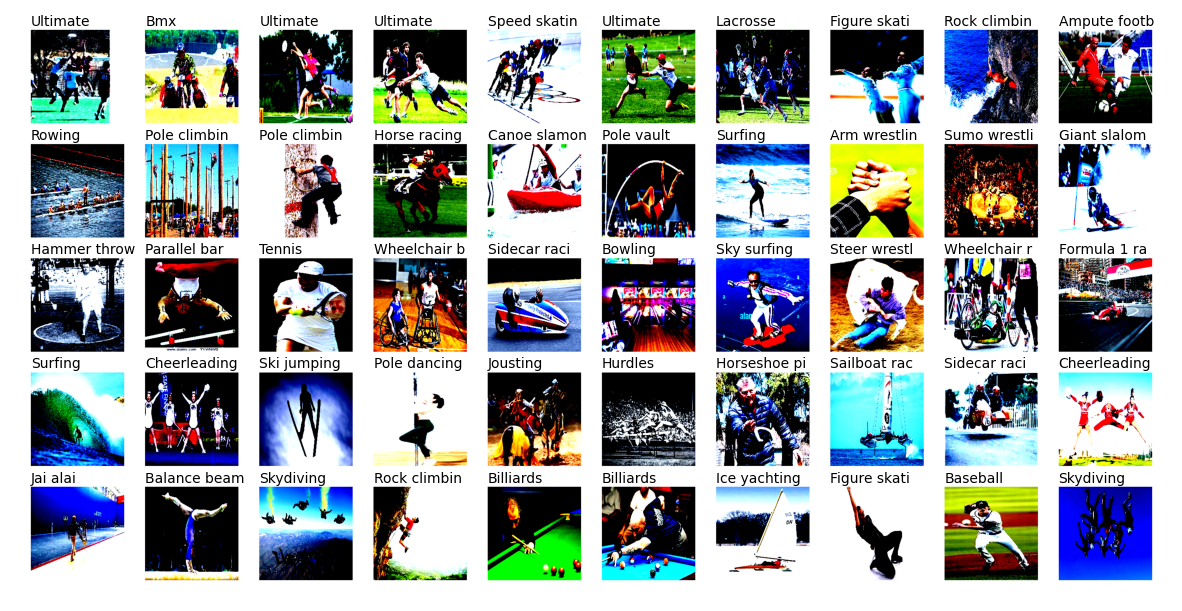

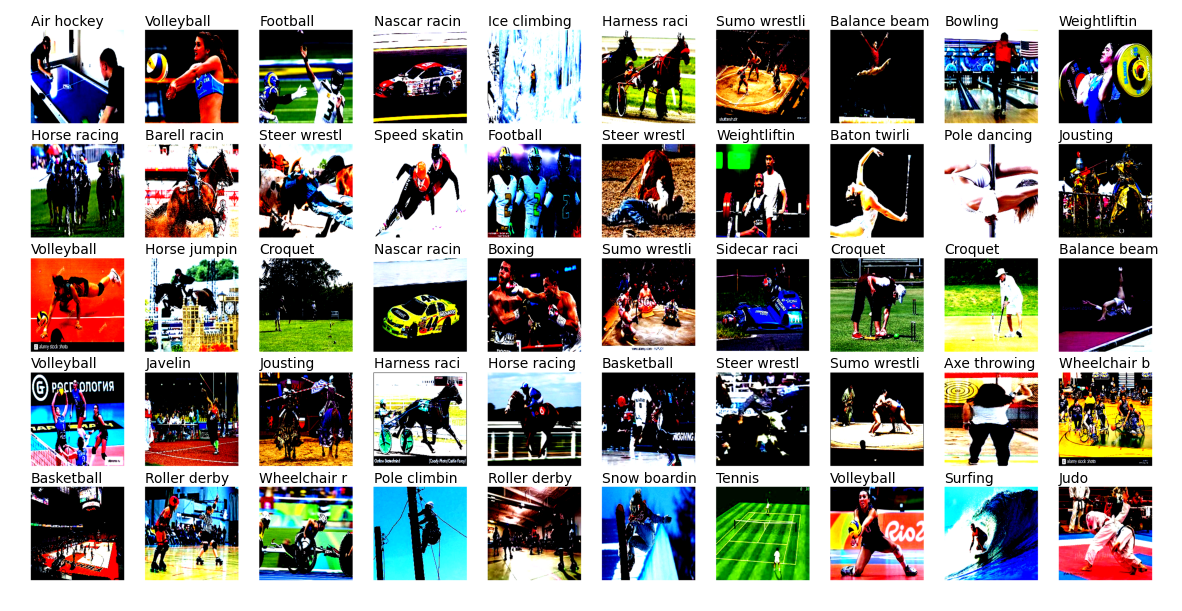

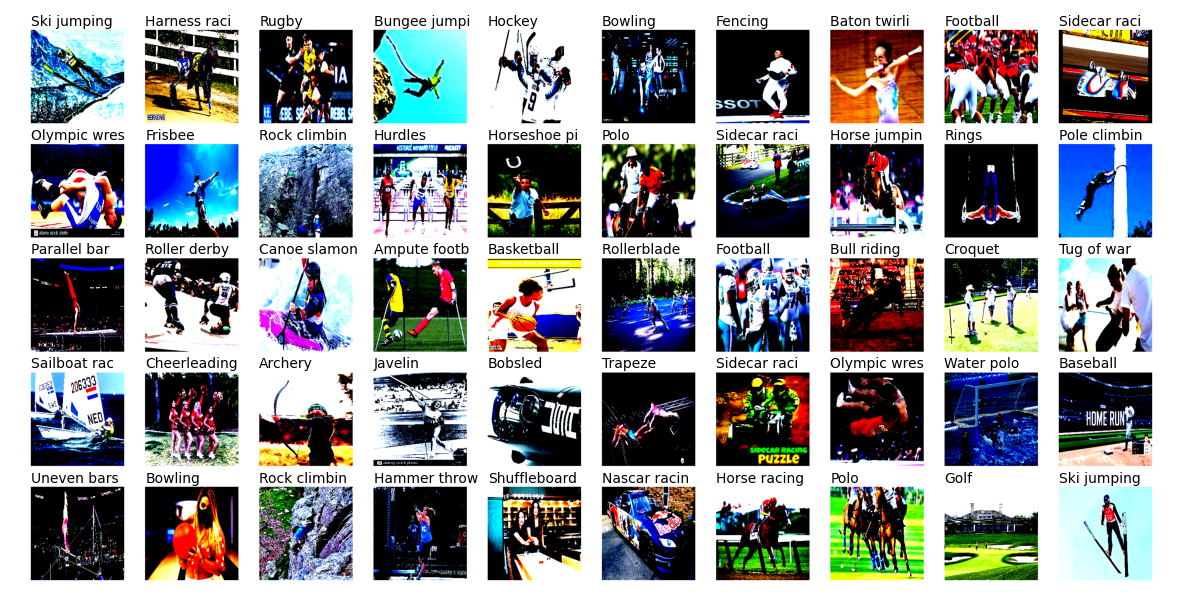

In [108]:
def show_images(loader, classes, batchs=1, nrow=10, padding=50, pad_value=50):
    for b, (images, labels) in enumerate(loader):
        if b == batchs:
            break

        images = images.to(torch.float32)
        image_grid = make_grid(images, nrow=nrow, padding=padding, pad_value=pad_value)
        image_grid = image_grid.permute(1, 2, 0)

        plt.figure(figsize=(15, 15))
        plt.imshow(image_grid)
        plt.axis('off')

        for i in range(images.size(0)):
            label = classes[labels[i].item()][:12].capitalize()
            row = i // nrow
            col = i % nrow
            x = col * (images.size(3) + padding) + padding
            y = row * (images.size(2) + padding) + padding * 0.75
            plt.text(x, y, label)

        plt.show()

show_images(train_loader, train_dataset.dataset.classes, batchs=3)

Total de imagens: 14493


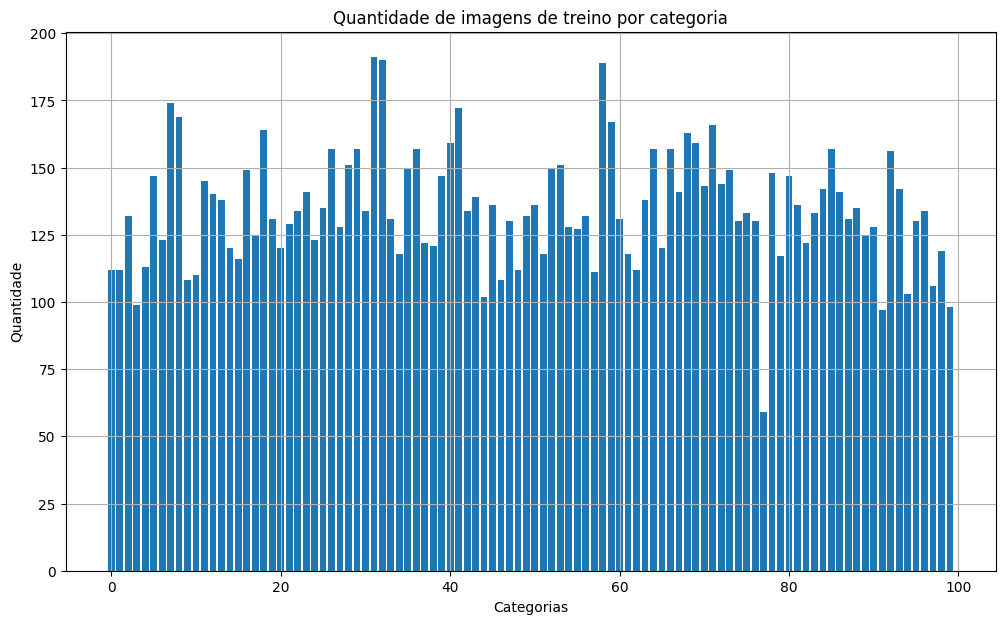

In [126]:
df = pd.read_csv(f'{data_path}/sports.csv')
data = df.loc[df['data set'] == 'train'].groupby('class id').count()
data = data.drop(columns=['labels', 'filepaths'])
data = data.rename(columns={'data set': 'count'})

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(data.index, data['count'])
ax.set_title('Quantidade de imagens de treino por categoria')
ax.set_xlabel('Categorias')
ax.set_ylabel('Quantidade')
ax.grid()

print(f'Total de imagens: {len(df.index)}')
plt.show()

## Modelos

### Blocos

In [110]:
def model_summary(model):
    total_params = sum(p.numel() for p in model.parameters())
    treinable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_treinable_params = total_params - treinable_params
    print(f'Parâmetros totais: {total_params}')
    print(f'Parâmetros treináveis: {treinable_params}')
    print(f'Parâmetros não treináveis: {non_treinable_params}')
    print('Camadas:')
    for p in model.parameters():
        print(f'\t{p.name if p.name != None else p.shape} -> {p.numel()}')

In [111]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, dtype=torch.float32):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size, padding=1).to(dtype)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size, padding=1).to(dtype)
        self.bn = nn.BatchNorm2d(channels)

    def forward(self, x):
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn(self.conv2(x)))
        return x

class MaxPoolBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pool_size=2, dtype=torch.float32):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size).to(dtype)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(pool_size)

    def forward(self, x):
        return F.relu(self.pool(F.leaky_relu(self.bn(self.conv(x)))))

class AvgPoolBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pool_size=2, dtype=torch.float32):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size).to(dtype)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.AvgPool2d(pool_size)

    def forward(self, x):
        return F.relu(self.pool(F.leaky_relu(self.bn(self.conv(x)))))

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out1x1, out3x3_reduce, out3x3, out5x5_reduce, out5x5, pool_proj, dtype=torch.float32):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1).to(dtype),
            nn.ReLU(inplace=True)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out3x3_reduce, kernel_size=1).to(dtype),
            nn.ReLU(inplace=True),
            nn.Conv2d(out3x3_reduce, out3x3, kernel_size=3, padding=1).to(dtype),
            nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out5x5_reduce, kernel_size=1).to(dtype),
            nn.ReLU(inplace=True),
            nn.Conv2d(out5x5_reduce, out5x5, kernel_size=5, padding=2).to(dtype),
            nn.ReLU(inplace=True)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1).to(dtype),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)
        return torch.cat([x1, x2, x3, x4], 1)

### Modelo 1

In [113]:
class Model1(nn.Module):
    def __init__(self, dtype=torch.float32, dropout=0):
        super().__init__()
        self.n = 16
        self.layer1 = MaxPoolBlock(3, 2 * self.n, dtype=dtype)
        self.layer2 = ResidualBlock(2 * self.n, dtype=dtype)
        self.layer3 = MaxPoolBlock(2 * self.n, 4 * self.n, dtype=dtype)
        self.layer4 = ResidualBlock(4 * self.n, dtype=dtype)
        self.layer5 = MaxPoolBlock(4 * self.n, 8 * self.n, dtype=dtype)
        self.layer6 = AvgPoolBlock(8 * self.n, 8 * self.n, dtype=dtype)
        self.dense = nn.Sequential(
            nn.MaxPool2d(3, 3).to(dtype=dtype),
            nn.Flatten(),
            nn.Linear(8 * self.n * 4**2, 16 * self.n).to(dtype=dtype),
            nn.Dropout(dropout),
            nn.Linear(16 * self.n, 8 * self.n).to(dtype=dtype),
            nn.Dropout(0.5 * dropout),
            nn.Linear(8 * self.n, 100).to(dtype=dtype),
        )

    def forward(self, x):
        x = self.layer1(x)
#         x = self.layer2(x) + x
        x = self.layer3(x)
#         x = self.layer4(x) + x
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.dense(x)
        return x

model_summary(Model1())

Parâmetros totais: 904420
Parâmetros treináveis: 904420
Parâmetros não treináveis: 0
Camadas:
	torch.Size([32, 3, 3, 3]) -> 864
	torch.Size([32]) -> 32
	torch.Size([32]) -> 32
	torch.Size([32]) -> 32
	torch.Size([32, 32, 3, 3]) -> 9216
	torch.Size([32]) -> 32
	torch.Size([32, 32, 3, 3]) -> 9216
	torch.Size([32]) -> 32
	torch.Size([32]) -> 32
	torch.Size([32]) -> 32
	torch.Size([64, 32, 3, 3]) -> 18432
	torch.Size([64]) -> 64
	torch.Size([64]) -> 64
	torch.Size([64]) -> 64
	torch.Size([64, 64, 3, 3]) -> 36864
	torch.Size([64]) -> 64
	torch.Size([64, 64, 3, 3]) -> 36864
	torch.Size([64]) -> 64
	torch.Size([64]) -> 64
	torch.Size([64]) -> 64
	torch.Size([128, 64, 3, 3]) -> 73728
	torch.Size([128]) -> 128
	torch.Size([128]) -> 128
	torch.Size([128]) -> 128
	torch.Size([128, 128, 3, 3]) -> 147456
	torch.Size([128]) -> 128
	torch.Size([128]) -> 128
	torch.Size([128]) -> 128
	torch.Size([256, 2048]) -> 524288
	torch.Size([256]) -> 256
	torch.Size([128, 256]) -> 32768
	torch.Size([128]) -> 128

### Modelo 2

In [114]:
class Model2(nn.Module):
    def __init__(self, dtype=torch.float32, dropout=0):
        super().__init__()
        self.inception1 = InceptionBlock(192, 64, 96, 128, 16, 32, 32, dtype=dtype)
        self.inception2 = InceptionBlock(256, 128, 128, 192, 32, 96, 64, dtype=dtype)
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3).to(dtype)
        self.conv2 = nn.Conv2d(64, 192, 3, stride=1, padding=1).to(dtype)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d((2, 2))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(23520, 100).to(dtype)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.pool(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model_summary(Model2())

Parâmetros totais: 3024788
Parâmetros treináveis: 3024788
Parâmetros não treináveis: 0
Camadas:
	torch.Size([64, 192, 1, 1]) -> 12288
	torch.Size([64]) -> 64
	torch.Size([96, 192, 1, 1]) -> 18432
	torch.Size([96]) -> 96
	torch.Size([128, 96, 3, 3]) -> 110592
	torch.Size([128]) -> 128
	torch.Size([16, 192, 1, 1]) -> 3072
	torch.Size([16]) -> 16
	torch.Size([32, 16, 5, 5]) -> 12800
	torch.Size([32]) -> 32
	torch.Size([32, 192, 1, 1]) -> 6144
	torch.Size([32]) -> 32
	torch.Size([128, 256, 1, 1]) -> 32768
	torch.Size([128]) -> 128
	torch.Size([128, 256, 1, 1]) -> 32768
	torch.Size([128]) -> 128
	torch.Size([192, 128, 3, 3]) -> 221184
	torch.Size([192]) -> 192
	torch.Size([32, 256, 1, 1]) -> 8192
	torch.Size([32]) -> 32
	torch.Size([96, 32, 5, 5]) -> 76800
	torch.Size([96]) -> 96
	torch.Size([64, 256, 1, 1]) -> 16384
	torch.Size([64]) -> 64
	torch.Size([64, 3, 7, 7]) -> 9408
	torch.Size([64]) -> 64
	torch.Size([192, 64, 3, 3]) -> 110592
	torch.Size([192]) -> 192
	torch.Size([100, 23520]) ->

### Aplicação do Modelo 1

Época 1/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4552, Acurácia:  90.08%, Precisão:  90.13%, F1:  90.06%
	Teste  - Perda: 0.3839, Acurácia:  89.40%, Precisão:  90.56%, F1:  88.93%
	Taxa de aprendizado: 0.000048


Época 2/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4475, Acurácia:  90.13%, Precisão:  90.16%, F1:  90.11%
	Teste  - Perda: 0.3829, Acurácia:  89.60%, Precisão:  90.82%, F1:  89.19%
	Taxa de aprendizado: 0.000045


Época 3/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4433, Acurácia:  90.48%, Precisão:  90.50%, F1:  90.46%
	Teste  - Perda: 0.3960, Acurácia:  89.60%, Precisão:  90.88%, F1:  89.07%
	Taxa de aprendizado: 0.000043


Época 4/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4392, Acurácia:  90.33%, Precisão:  90.37%, F1:  90.32%
	Teste  - Perda: 0.3888, Acurácia:  89.60%, Precisão:  90.77%, F1:  89.25%
	Taxa de aprendizado: 0.000041


Época 5/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4426, Acurácia:  89.93%, Precisão:  89.95%, F1:  89.91%
	Teste  - Perda: 0.3878, Acurácia:  90.00%, Precisão:  91.16%, F1:  89.63%
	Taxa de aprendizado: 0.000039


Época 6/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4399, Acurácia:  90.59%, Precisão:  90.63%, F1:  90.58%
	Teste  - Perda: 0.3895, Acurácia:  89.60%, Precisão:  90.72%, F1:  89.18%
	Taxa de aprendizado: 0.000037


Época 7/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4309, Acurácia:  90.74%, Precisão:  90.76%, F1:  90.72%
	Teste  - Perda: 0.3923, Acurácia:  90.20%, Precisão:  91.50%, F1:  89.84%
	Taxa de aprendizado: 0.000035


Época 8/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4373, Acurácia:  90.58%, Precisão:  90.62%, F1:  90.57%
	Teste  - Perda: 0.3924, Acurácia:  89.80%, Precisão:  91.09%, F1:  89.39%
	Taxa de aprendizado: 0.000033


Época 9/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4388, Acurácia:  90.36%, Precisão:  90.41%, F1:  90.35%
	Teste  - Perda: 0.3962, Acurácia:  89.60%, Precisão:  90.79%, F1:  89.14%
	Taxa de aprendizado: 0.000032


Época 10/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.4357, Acurácia:  90.39%, Precisão:  90.42%, F1:  90.36%
	Teste  - Perda: 0.3899, Acurácia:  89.60%, Precisão:  90.49%, F1:  89.25%
	Taxa de aprendizado: 0.000030


Perda no treino Acurácia no treino Precisão no treino F1 no treino  \
Época                                                                      
1                0,46             90.08%             90.13%       90.06%   
2                0,45             90.13%             90.16%       90.11%   
3                0,44             90.48%             90.50%       90.46%   
4                0,44             90.33%             90.37%       90.32%   
5                0,44             89.93%             89.95%       89.91%   
6                0,44             90.59%             90.63%       90.58%   
7                0,43             90.74%             90.76%       90.72%   
8                0,44             90.58%             90.62%       90.57%   
9                0,44             90.36%             90.41%       90.35%   
10               0,44             90.39%             90.42%       90.36%   

      Perda no teste Acurácia no teste Precisão no teste F1 no teste  \
Época                                                                  
1               0,38            89.40%            90.56%      88.93%   
2               0,38            89.60%            90.82%      89.19%   
3               0,40            89.60%            90.88%      89.07%   
4               0,39            89.60%            90.77%      89.25%   
5               0,39            90.00%            91.16%      89.63%   
6               0,39            89.60%            90.72%      89.18%   
7               0,39            90.20%            91.50%      89.84%   
8               0,39            89.80%            91.09%      89.39%   
9               0,40            89.60%            90.79%      89.14%   
10              0,39            89.60%            90.49%      89.25%   

      Taxa de aprendizado  
Época                      
1                0,000048  
2                0,000045  
3                0,000043  
4                0,000041  
5                0,000039  
6                0,000037  
7                0,000035  
8                0,000033  
9                0,000032  
10               0,000030

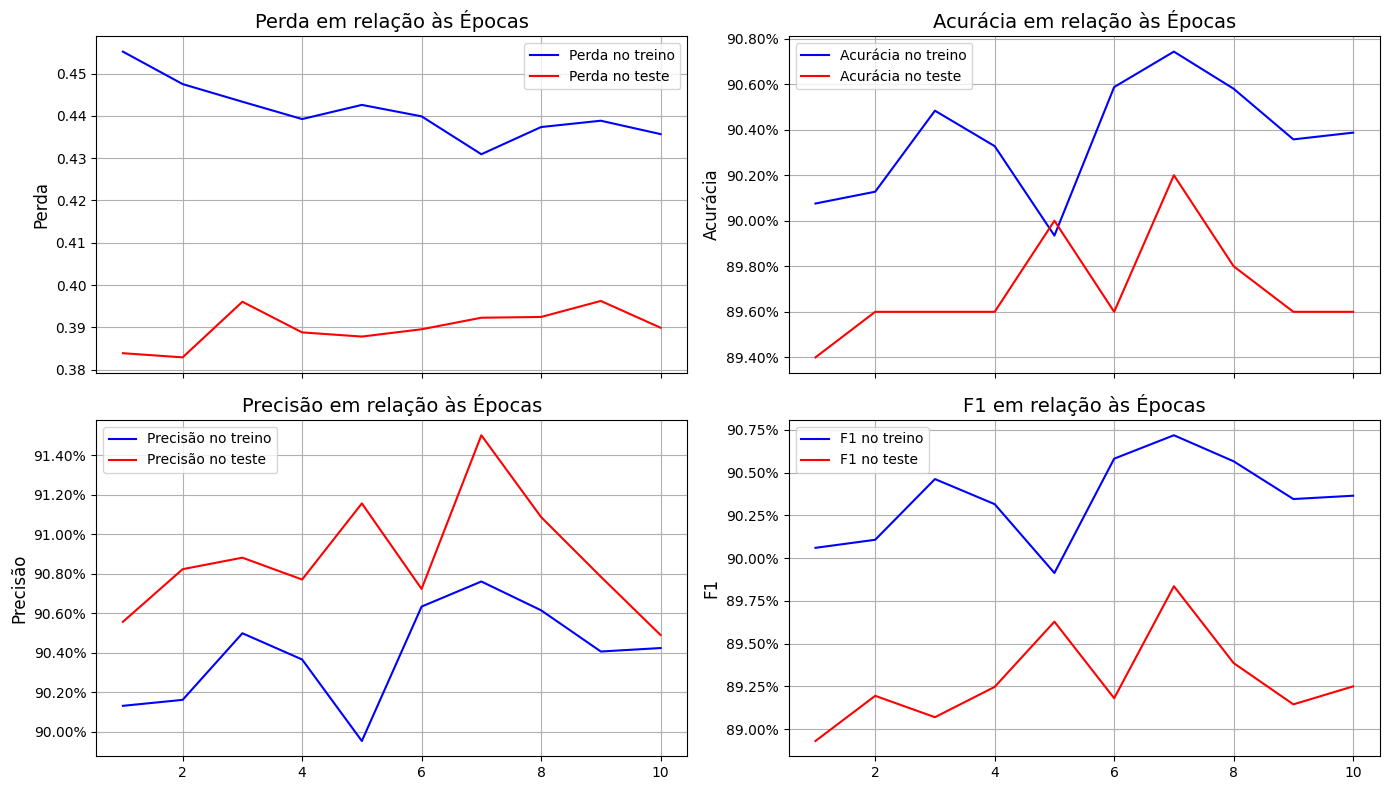

In [57]:
epochs1 = 10
lr1 = 5e-5
weight_decay1 = 1e-2
dropout1 = 0.35
gamma1 = 0.95

model1 = Model1(dtype=dtype, dropout=dropout1).to(device)
trainer1 = torch.optim.SGD(model1.parameters(), lr=lr1, weight_decay=weight_decay1)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(trainer1, gamma=gamma1)
loss1 = nn.CrossEntropyLoss()
try:
    model1 = load_model(model1, f'{working_path}/model1.pth').to(device)
#     model1 = load_model(model1, '/kaggle/input/rnp-model1/pytorch/1/11/model1 (12).pth').to(device)
except (FileNotFoundError, RuntimeError) as e:
    print(f'Falha ao carregar o modelo de {working_path}. Novo modelo criado.')

model1, result1 = fit(epochs1, model1, train_loader, test_loader, trainer1, loss1, scheduler1, device)

display(format_dataframe(result1))
plot_metrics(result1)
save_model(model1, f'{working_path}/model1.pth')

### Aplicação do Modelo 2

Época 1/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1862, Acurácia:  95.63%, Precisão:  95.65%, F1:  95.63%
	Teste  - Perda: 0.2445, Acurácia:  95.20%, Precisão:  95.84%, F1:  94.98%
	Taxa de aprendizado: 0.000095


Época 2/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1781, Acurácia:  95.89%, Precisão:  95.92%, F1:  95.89%
	Teste  - Perda: 0.2458, Acurácia:  95.40%, Precisão:  96.13%, F1:  95.23%
	Taxa de aprendizado: 0.000090


Época 3/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1798, Acurácia:  95.87%, Precisão:  95.90%, F1:  95.87%
	Teste  - Perda: 0.2491, Acurácia:  95.60%, Precisão:  96.29%, F1:  95.50%
	Taxa de aprendizado: 0.000086


Época 4/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1842, Acurácia:  95.85%, Precisão:  95.88%, F1:  95.85%
	Teste  - Perda: 0.2486, Acurácia:  95.40%, Precisão:  96.13%, F1:  95.30%
	Taxa de aprendizado: 0.000081


Época 5/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1741, Acurácia:  95.87%, Precisão:  95.89%, F1:  95.87%
	Teste  - Perda: 0.2508, Acurácia:  95.20%, Precisão:  95.84%, F1:  95.05%
	Taxa de aprendizado: 0.000077


Época 6/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1756, Acurácia:  95.96%, Precisão:  95.99%, F1:  95.96%
	Teste  - Perda: 0.2496, Acurácia:  95.20%, Precisão:  95.84%, F1:  95.05%
	Taxa de aprendizado: 0.000074


Época 7/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1699, Acurácia:  96.27%, Precisão:  96.30%, F1:  96.27%
	Teste  - Perda: 0.2501, Acurácia:  95.00%, Precisão:  95.75%, F1:  94.87%
	Taxa de aprendizado: 0.000070


Época 8/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1727, Acurácia:  96.09%, Precisão:  96.11%, F1:  96.08%
	Teste  - Perda: 0.2493, Acurácia:  95.40%, Precisão:  96.01%, F1:  95.25%
	Taxa de aprendizado: 0.000066


Época 9/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1783, Acurácia:  95.82%, Precisão:  95.84%, F1:  95.82%
	Teste  - Perda: 0.2511, Acurácia:  95.20%, Precisão:  95.84%, F1:  95.05%
	Taxa de aprendizado: 0.000063


Época 10/10:   0%|          | 0/270 [00:00<?, ?it/s]

	Treino - Perda: 0.1728, Acurácia:  96.09%, Precisão:  96.12%, F1:  96.09%
	Teste  - Perda: 0.2549, Acurácia:  95.40%, Precisão:  96.01%, F1:  95.25%
	Taxa de aprendizado: 0.000060


Perda no treino Acurácia no treino Precisão no treino F1 no treino  \
Época                                                                      
1                0,19             95.63%             95.65%       95.63%   
2                0,18             95.89%             95.92%       95.89%   
3                0,18             95.87%             95.90%       95.87%   
4                0,18             95.85%             95.88%       95.85%   
5                0,17             95.87%             95.89%       95.87%   
6                0,18             95.96%             95.99%       95.96%   
7                0,17             96.27%             96.30%       96.27%   
8                0,17             96.09%             96.11%       96.08%   
9                0,18             95.82%             95.84%       95.82%   
10               0,17             96.09%             96.12%       96.09%   

      Perda no teste Acurácia no teste Precisão no teste F1 no teste  \
Época                                                                  
1               0,24            95.20%            95.84%      94.98%   
2               0,25            95.40%            96.13%      95.23%   
3               0,25            95.60%            96.29%      95.50%   
4               0,25            95.40%            96.13%      95.30%   
5               0,25            95.20%            95.84%      95.05%   
6               0,25            95.20%            95.84%      95.05%   
7               0,25            95.00%            95.75%      94.87%   
8               0,25            95.40%            96.01%      95.25%   
9               0,25            95.20%            95.84%      95.05%   
10              0,25            95.40%            96.01%      95.25%   

      Taxa de aprendizado  
Época                      
1                0,000095  
2                0,000090  
3                0,000086  
4                0,000081  
5                0,000077  
6                0,000074  
7                0,000070  
8                0,000066  
9                0,000063  
10               0,000060

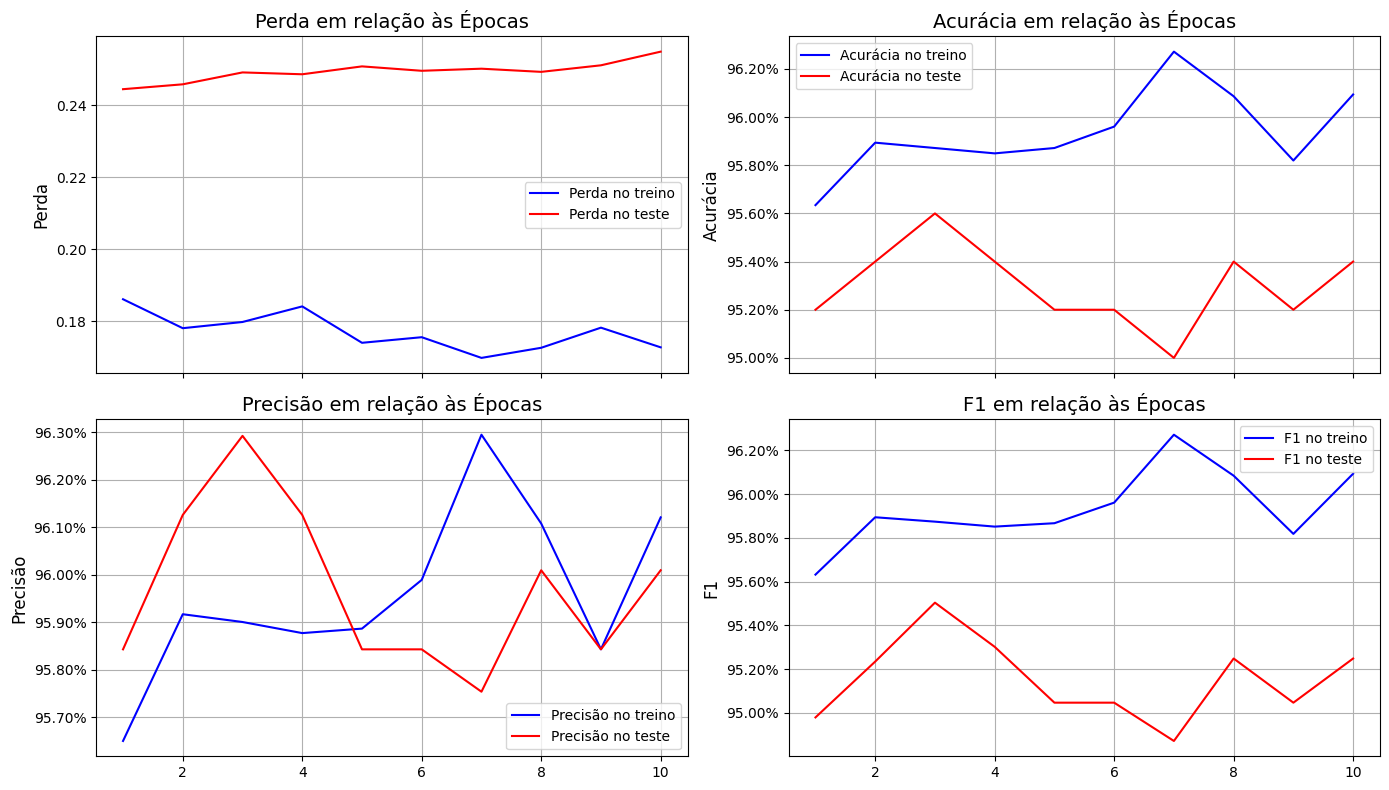

In [25]:
epochs2 = 10
lr2 = 1e-4
weight_decay2 = 1e-3
dropout2 = 0.3
gamma2 = 0.95

model2 = Model2(dtype=dtype, dropout=dropout2).to(device)
trainer2 = torch.optim.SGD(model2.parameters(), lr=lr2, weight_decay=weight_decay2)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(trainer2, gamma=gamma2)
loss2 = nn.CrossEntropyLoss()
try:
    model2 = load_model(model2, f'{working_path}/model2.pth').to(device)
#     model2 = load_model(model2, '/kaggle/input/rnp-model2/pytorch/2/6/model2 (6).pth').to(device)
except (FileNotFoundError, RuntimeError) as e:
    print(f'Falha ao carregar o modelo de {working_path}. Novo modelo criado.')

model2, result2 = fit(epochs2, model2, train_loader, test_loader, trainer2, loss2, scheduler2, device)

display(format_dataframe(result2))
plot_metrics(result2)
save_model(model2, f'{working_path}/model2.pth')

### Validação do Modelo 1

40.0%: 1 classes
60.0%: 5 classes
80.0%: 26 classes
100.0%: 68 classes


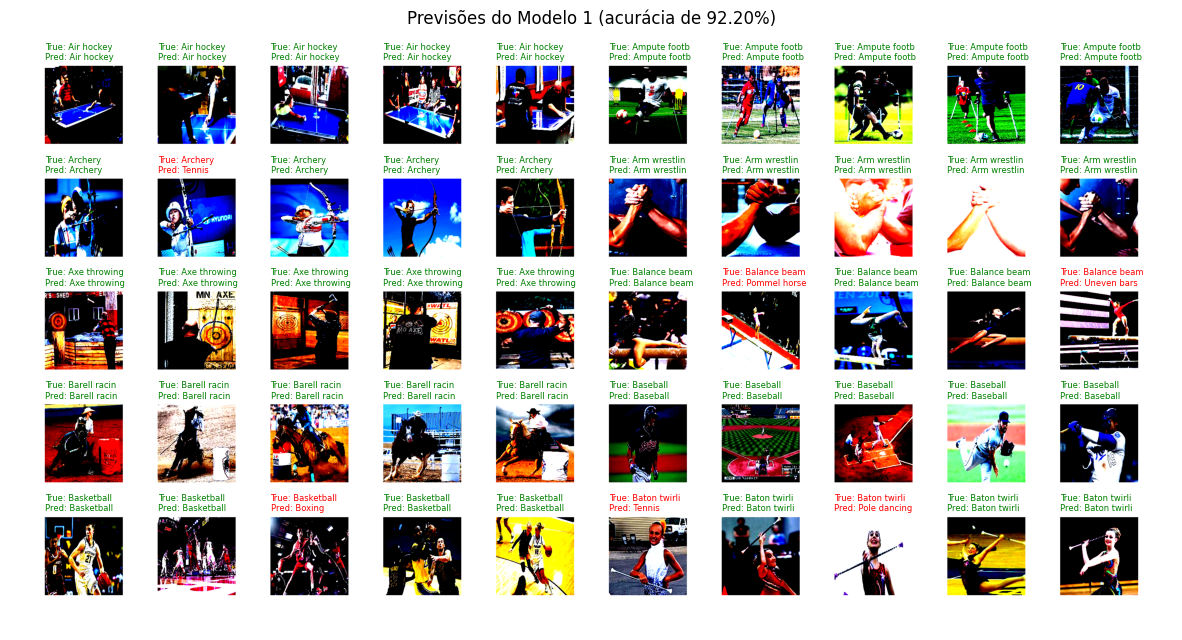

In [115]:
acc1, class_acc1 = validate_accuracy(model1, valid_loader, device)
for key, values in invert_dict(class_acc1).items():
    print(f'{key * 100}%: {len(values)} classes')
title1 = f'Previsões do Modelo 1 (acurácia de {acc1 * 100:.2f}%)'
show_predictions(model1, valid_loader, valid_dataset.dataset.classes, device, title=title1)

### Validação do Modelo 2

80.0%: 8 classes
100.0%: 92 classes


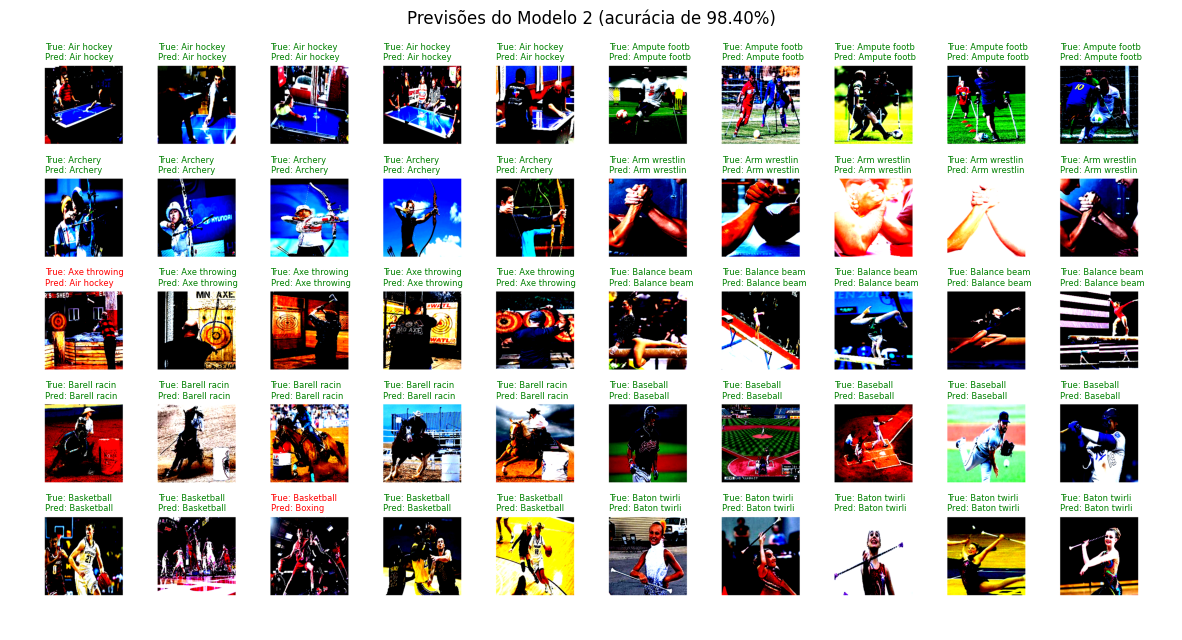

In [116]:
acc2, class_acc2 = validate_accuracy(model2, valid_loader, device)
for key, values in invert_dict(class_acc2).items():
    print(f'{key * 100}%: {len(values)} classes')
title2 = f'Previsões do Modelo 2 (acurácia de {acc2 * 100:.2f}%)'
show_predictions(model2, valid_loader, valid_dataset.dataset.classes, device, title=title2)

### Teste do Modelo 1 com uma foto minha

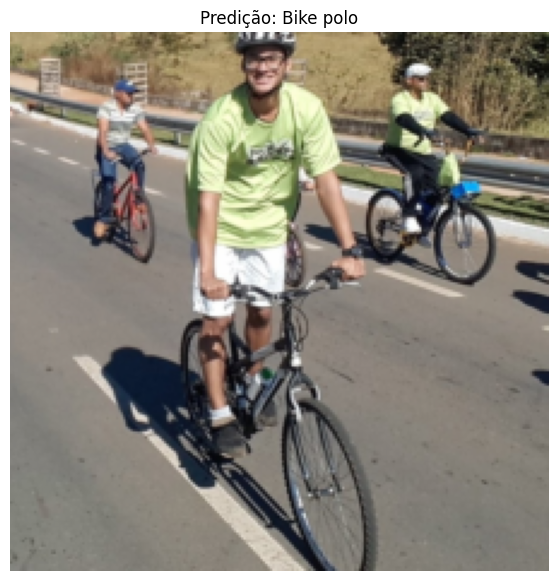

In [117]:
predict_image(model1, '/kaggle/input/testes/ciclismo.jpg', valid_dataset.dataset.classes, dtype=dtype, device=device)

### Teste do Modelo 2 com uma foto minha

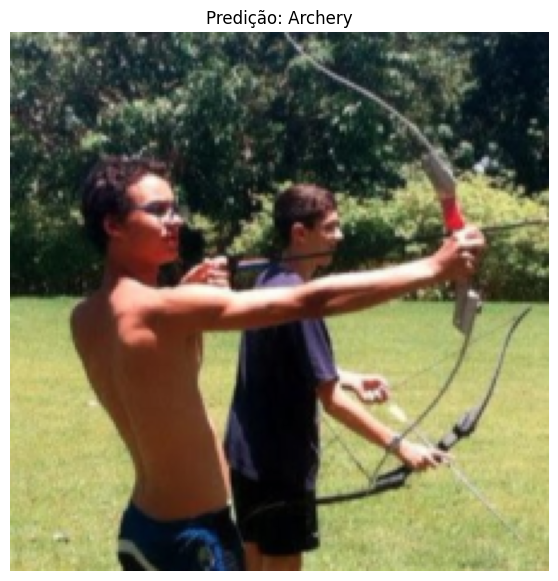

In [118]:
predict_image(model2, '/kaggle/input/testes/arco-e-flecha.jpg', valid_dataset.dataset.classes, dtype=dtype, device=device)

## Extra

Perda no treino Acurácia no treino Perda no teste Acurácia no teste
107             2,18             43,31%           1,86            50,80%
324             1,16             68,94%           1,33            63,60%
335             1,08             71,21%           1,37            61,60%
619              0,8             77,88%           1,01            70,80%
704             0,93             73,88%           1,15            69,00%
851             0,74             80,26%           0,85            75,20%
1043            0,51             88,55%           0,66            81,60%
1049             0,5             88,42%           0,65            82,00%

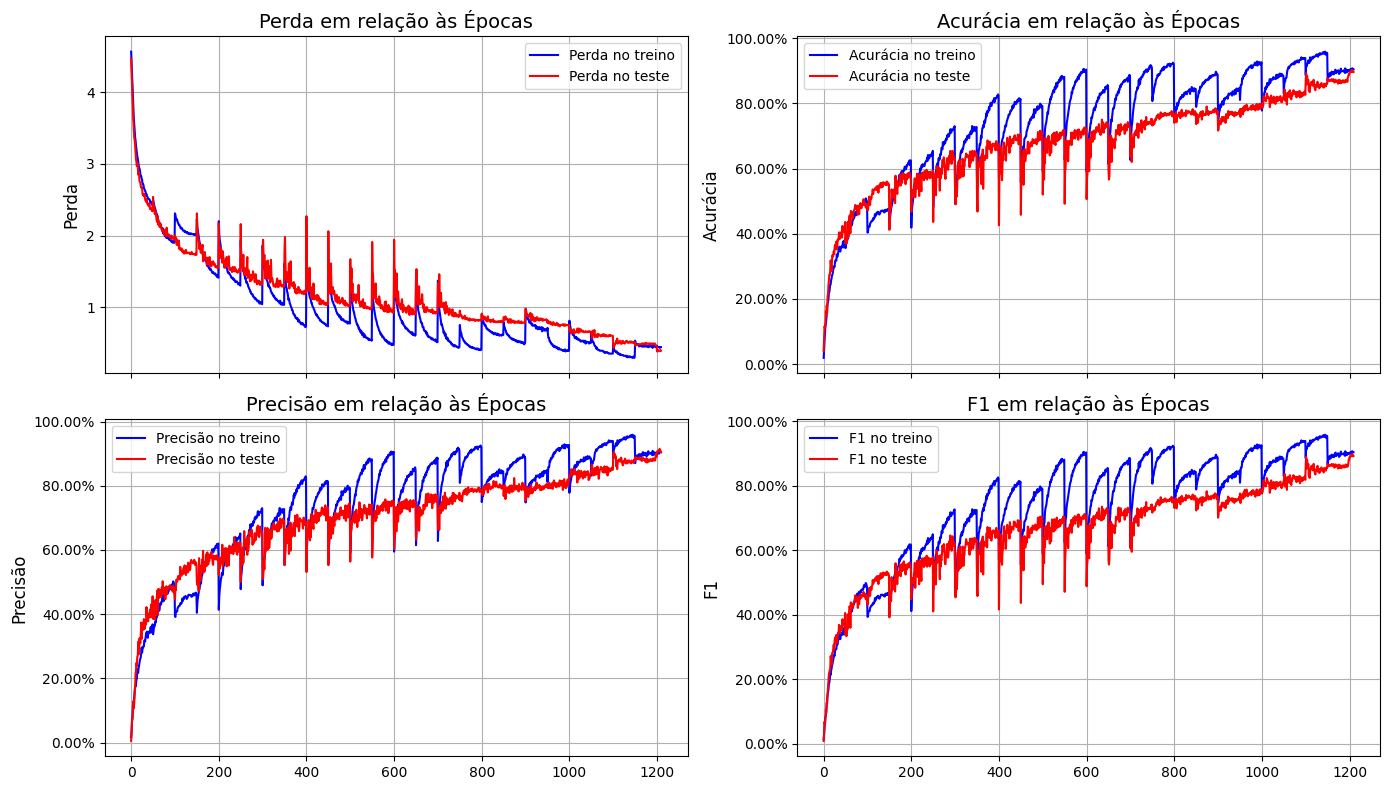

In [119]:
df1 = pd.read_excel(historic_path, sheet_name='Model1')
df1_sample = df1.sample(n=8)
df1_sample = df1_sample.loc[:, ['Perda no treino', 'Acurácia no treino', 'Perda no teste', 'Acurácia no teste']]
df1_sample = df1_sample.sort_index()
df1_sample = df1_sample.map(lambda x: f'{x}'.replace('.', ','))
display(df1_sample)
plot_metrics(reorganize_data(df1))

Perda no treino Acurácia no treino Perda no teste Acurácia no teste
27             2,67             33,58%           3,08            26,40%
33             2,38             40,97%           2,96            30,60%
253             1,0             74,50%           1,64            57,40%
388            0,94             74,30%            0,9            75,20%
409            0,91             75,27%           0,81            78,80%
419            0,47             88,73%           0,72            81,00%
455            0,34             92,04%           0,47            88,40%
464            0,35             91,22%           0,43            89,80%

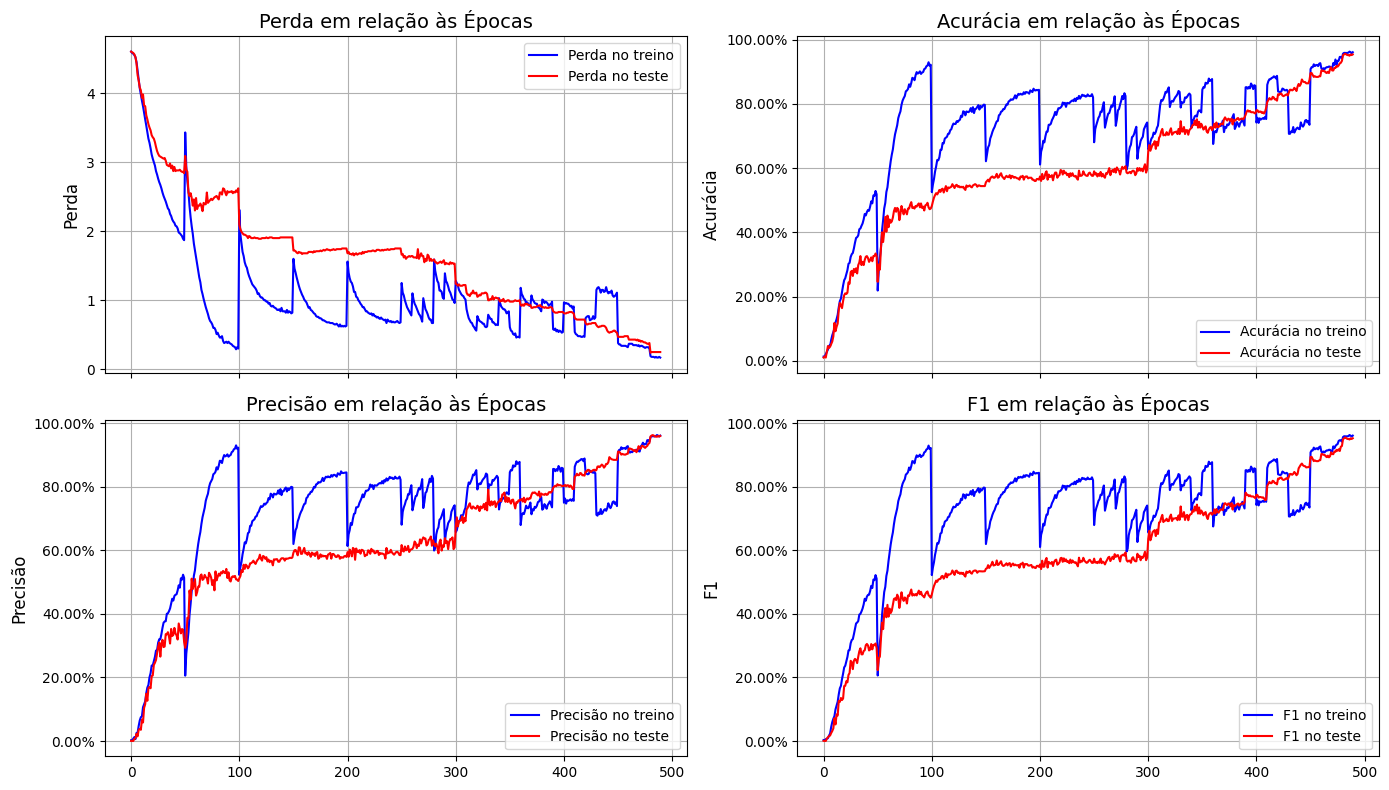

In [120]:
df2 = pd.read_excel(historic_path, sheet_name='Model2')
df2_sample = df2.sample(n=8)
df2_sample = df2_sample.loc[:, ['Perda no treino', 'Acurácia no treino', 'Perda no teste', 'Acurácia no teste']]
df2_sample = df2_sample.sort_index()
df2_sample = df2_sample.map(lambda x: f'{x}'.replace('.', ','))
display(df2_sample)
plot_metrics(reorganize_data(df2))